## Task 1 Gate Tomography

When designing a set of universal gates, one must prove that any unitary operation can be performed by combining gates of that set, which is known as circuit equivalence. In this case, you have to find the parameters of the U3 gates:
$$
U 3(\theta, \phi, \lambda)=\left(\begin{array}{cc}
\cos \left(\frac{\theta}{2}\right) & -e^{i \lambda} \sin \left(\frac{\theta}{2}\right) \\
e^{i \phi} \sin \left(\frac{\theta}{2}\right) & e^{i(\phi+\lambda)} \cos \left(\frac{\theta}{2}\right)
\end{array}\right)
$$
such that the following circuit is equivalent to a Toffoli gate, in which the U3 gates are marked with '?':

<img src="1Problem_Circuit.JPG" width="500">


NOTE: The parameters of the U3 gates might not be the same for both!



## Begging of Resolution

In [1]:
%matplotlib inline
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit.circuit.library import CCXGate
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

Let's first replicate the Quantum Gate of the problem, replacing by an unkown gate if no parameters are given

In [2]:
def circuit(params = None):
    """
    Builds the quantum circuit with 6 parameters for the two U3 gates.
    
    params: [theta1, phi1, lambda1, theta2, phi2, lambda2]
    """
    qc = QuantumCircuit(3)

    if params is None: 
        unkw_gate = Gate(name='?', num_qubits=1, params=[])
    else:
        theta1, phi1, lambda1 = params[0], params[1], params[2]
        theta2, phi2, lambda2 = params[3], params[4], params[5]
    
    # --- Circuit Construction ---
    
    qc.t(0)
    qc.cx(0, 1)
    qc.tdg(1)
    qc.cx(0, 1)
    qc.t(1)

    # 1st Unkown gate
    if params is None:
        qc.append(unkw_gate, [2])
    else:
        qc.u(theta1, phi1, lambda1, 2)
    
    qc.cx(1, 2)
    qc.tdg(2)
    qc.cx(0, 2)
    qc.t(2)
    qc.cx(1, 2)

    # 2nd Unkknow gate
    if params is None:
        qc.append(unkw_gate, [2])
    else:
        qc.u(theta2, phi2, lambda2, 2)
        
    qc.cx(0, 2)
    qc.t(2)
    qc.h(2)
    
    return qc

     ┌───┐                                                                     
q_0: ┤ T ├──■───────────■─────────────────────■───────────────────■────────────
     └───┘┌─┴─┐┌─────┐┌─┴─┐┌───┐              │                   │            
q_1: ─────┤ X ├┤ Tdg ├┤ X ├┤ T ├──■───────────┼─────────■─────────┼────────────
     ┌───┐└───┘└─────┘└───┘└───┘┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌───┐┌─┴─┐┌───┐┌───┐
q_2: ┤ ? ├──────────────────────┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ ? ├┤ X ├┤ T ├┤ H ├
     └───┘                      └───┘└─────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘


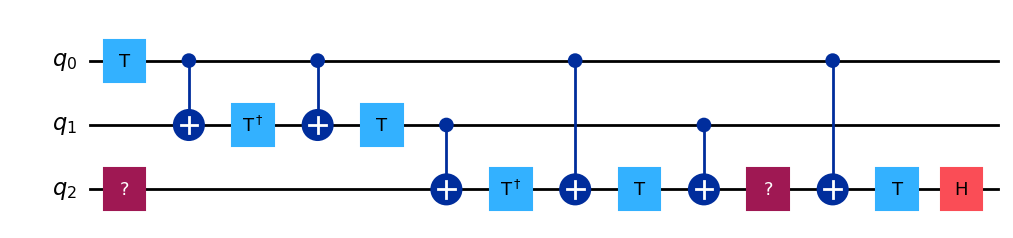

In [3]:
# Plotting
qc0 = circuit(params = None)
print(qc0.draw('text'))
qc0.draw('mpl')

Since the unknown quantum gates form a linear reversible problem, we can achieve the solution analitically or by optimization. Due to the nature of the screening task, it is more appropriate to formulate it as an optimization problem.

we cannot choose a mean square cost function since is sensible to global phase and in quantum circuits this is indistinguible. A fidelity cost function is better, for pure states is (Nielsen & Chuang):

$$
Cost = 1 - F
$$

$$
F = \frac{1}{d}|Tr(V^{\dagger}U)|
$$

, where d is the Hilbert's dimension space ($2^3$ in this case) and $V$, $U$ the compared quantum circuits.

In [4]:
# TARGET OPERATOR
target_op = Operator(CCXGate())

In [5]:
def get_fidelity(circuit, target_op):
    
    # We must transpile to gates the Operator backend understands
    basis_gates = ['u', 'cx'] 
    circuit_op = Operator(transpile(circuit, basis_gates=basis_gates))
    
    d = target_op.dim[0]
    fidelity = np.abs(np.trace(target_op.conjugate().transpose() @ circuit_op)) / d
    return fidelity

def cost_function(params):

    qc = circuit(params)
    fidelity  = get_fidelity(qc, target_op)

    return 1 - fidelity

Since Fidelity is computationally expensive, COBYLA is used.

In [6]:
from scipy.optimize import minimize

# Initial guess
initial_params = np.zeros(6)

print("Starting optimization")

# Run the optimizer.
result = minimize(cost_function, 
                  initial_params, 
                  method='COBYLA',
                  options={'maxiter': 2000, 'tol': 1e-6})

print("Optimization complete")

# -Format
if result.success and result.fun < 1e-5:
    print(f"\n Done! Final cost: {result.fun:.2e}")
    final_params = result.x
    
    # Normalize angles 
    final_params_normalized = (final_params + np.pi) % (2 * np.pi) - np.pi
    
    print("\nFound parameters:")
    print(f"  Gate 1: theta={final_params_normalized[0]:.4f}, phi={final_params_normalized[1]:.4f}, lambda={final_params_normalized[2]:.4f}")
    
    print(f"  Gate 2: theta={final_params_normalized[3]:.4f}, phi={final_params_normalized[4]:.4f}, lambda={final_params_normalized[5]:.4f}")

else:
    print(f"\n Optimization failed or did not converge")
    print(f"Final cost: {result.fun}")

Starting optimization
Optimization complete

 Done! Final cost: 1.70e-13

Found parameters:
  Gate 1: theta=-1.5708, phi=-3.1416, lambda=0.0000
  Gate 2: theta=0.0000, phi=-0.4846, lambda=-0.3008


That is, the gates are:
$$ U3(−\pi/2, −\pi, 0) = H $$
$$ U3(0, -0.4846, -0.3008) \equiv T^{\dagger} $$


In [7]:
# Let's check our results

#params_optimizer = [
#    -np.pi/2, -np.pi, 0.0000,          # U1 (Hadamard ~ -1.5708, -3.1416, 0.0000)
#    0.0000, -np.pi/4, 0.0000           # U2 (T-dagger ~ 0.0000, -0.4846, -0.3008, where phi+lambda ≈ -pi/4)
#]

qc_optimizer = circuit(final_params_normalized)
fid_optimizer = get_fidelity(qc_optimizer, target_op)
print(f"Solution:")
print(f"  Fidelity = {fid_optimizer:.10f}")
print(f"  Is Correct? -> {np.isclose(fid_optimizer, 1.0)}\n")

Solution:
  Fidelity = 1.0000000000
  Is Correct? -> True



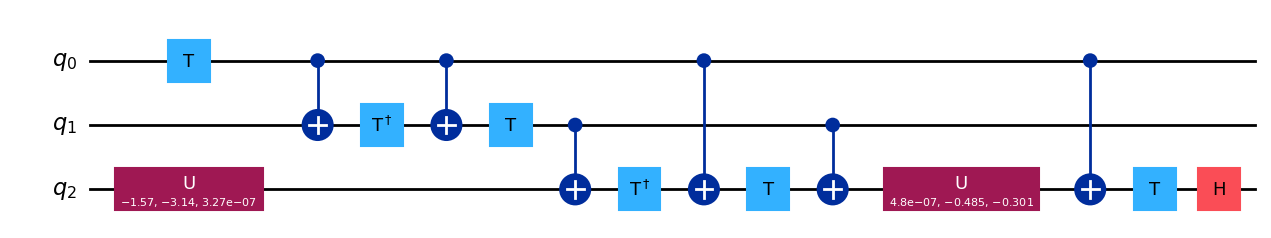

In [8]:
qc_optimizer.draw('mpl')

### Visualizing Cost Function

Only for fun. Let's plot some cost function

In [9]:
x = [-2* np.pi, 2*np.pi]
theta_range = np.arange(x[0], x[1], 0.25)

In [10]:
def wrapped_cost(p0, p1):
    param = final_params_normalized.copy()
    param[0] = p0
    param[3] = p1
    return cost_function(param)

theta0_grid, theta1_grid = np.meshgrid(theta_range, theta_range)
cost_map = np.vectorize(wrapped_cost)(theta0_grid, theta1_grid)
    

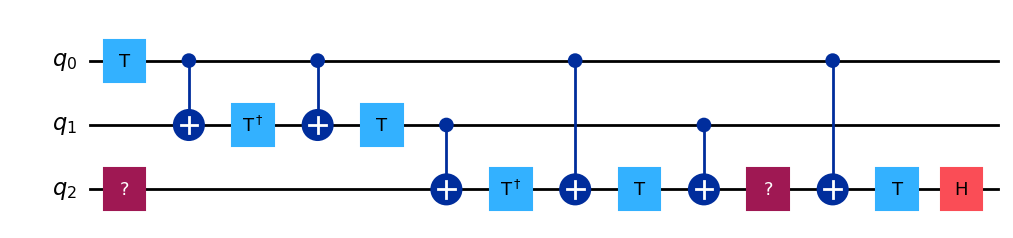

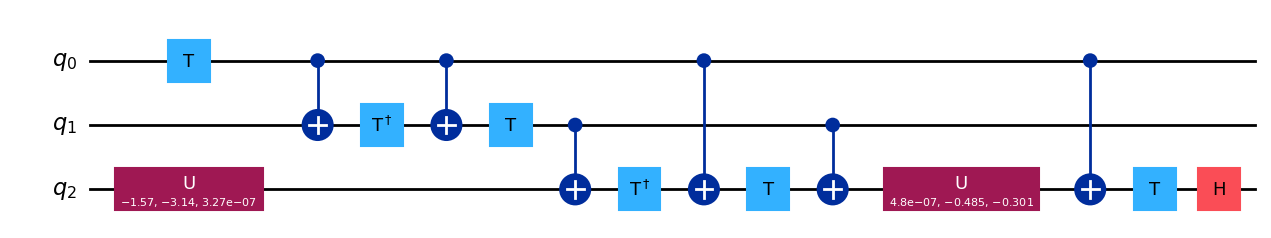

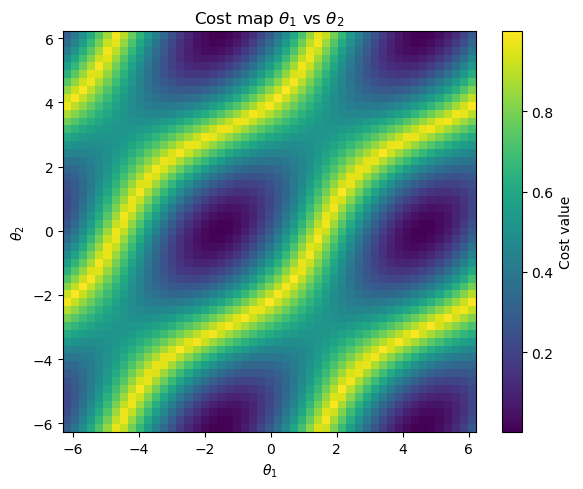

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cost_map,
               extent=[theta_range[0], theta_range[-1], theta_range[0], theta_range[-1]],
               origin='lower',
               aspect='auto',
               cmap='viridis')


cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cost value')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title(r'Cost map $\theta_1$ vs $\theta_2$')

plt.tight_layout()
plt.show()

Of course the theta is inside a cosine function and is not improsive to have more than a local minimun

In [12]:
x = [-2* np.pi, 2*np.pi]
phi_range = np.arange(x[0], x[1], 0.25)

In [13]:
def wrapped_cost(p0, p1):
    param = final_params_normalized.copy()
    param[1] = p0
    param[4] = p1
    return cost_function(param)
    
phi0_grid, phi1_grid = np.meshgrid(phi_range, phi_range) 
cost_map = np.vectorize(wrapped_cost)(phi0_grid, phi1_grid)
    

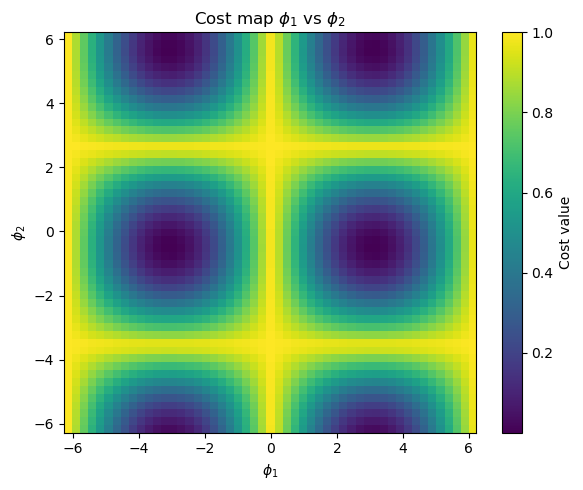

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cost_map,
               extent=[phi_range[0], phi_range[-1], phi_range[0], phi_range[-1]],
               origin='lower',
               aspect='auto',
               cmap='viridis')
# vmin = 0.65, vmax = 0.7

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cost value')
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_title(r'Cost map $\phi_1$ vs $\phi_2$')

plt.tight_layout()
plt.show()

In [16]:
final_params_normalized

array([-1.57079546e+00, -3.14159252e+00,  3.26931980e-07,  4.79797660e-07,
       -4.84574541e-01, -3.00824458e-01])